In [1]:
batch_size = 465
learning_rate = 0.0098388848049504
dropout_rate = 0.28932744984147474
kernel_size = 3


In [2]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from utils_cells import get_images_list, transform_image, transform_target, resize_with_padding
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torchvision.transforms.functional as F
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
import cv2
from sklearn.model_selection import train_test_split
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchmetrics import Precision, Recall
import numpy as np
import datetime
import random
import time
import torchvision.models as models
import wandb

import random

class ImageDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None, reduce=False):
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = shuffle(self.load_dataset(data_path))

    def load_dataset(self, path):
        files = os.listdir(path)
        dataset_final = pd.DataFrame()
        dataset_final['filename'] = []
        dataset_final['class'] = []
        for filename in files:
            dataset = pd.DataFrame()
            if filename.endswith('.txt'):
                files = get_images_list(f'{path}/{filename}')
                dataset['filename'] = files
                dataset['class'] = filename.split('_')[1][:-3]
                dataset_final = pd.concat([dataset_final, dataset], ignore_index=True)
        return dataset_final                
                          
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = cv2.imread(f'{self.dataset["filename"].loc[idx]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
        #image = resize_with_padding(image, (32, 32))
        image = image.astype(np.float32)
        image = image/255.0
        image = self.transform(image = image)['image'] if self.transform is not None else image

        target = self.dataset["class"].loc[idx]

        if target == 'normal.':
            target_ = [1, 0, 0, 0]
        elif target == 'inflamatory.':
            target_ = [0, 1, 0, 0]
        elif target == 'tumor.':
            target_ = [0, 0, 1, 0]
        elif target == 'other.':
            target_ = [0, 0, 0, 1]
        else:
            print(target)
        
        image = F.to_tensor(image)
        
       
     

        """To see transorms use:
            image, target = trainset[15]
            image = image.numpy()
            image=np.swapaxes(image,0,1)
            image=np.swapaxes(image,1,2)
            plt.imshow(image)"""

        return image.float(), torch.Tensor(np.array(target_, dtype=np.float32))





/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2233)



from albumentations import (
    Compose,
    Resize,
    OneOf,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    VerticalFlip,
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
)

transform = Compose(
    [
        OneOf([RandomBrightness(limit=0.0, p=1), RandomContrast(limit=0.1, p=0.8)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.7,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
    ]
)





/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:2587: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [4]:
trainset = ImageDataset(data_path='train_data', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = ImageDataset(data_path='validation_data')
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model setup
model = resnet50()
model.conv1 = nn.Conv2d(3, 64, kernel_size=(kernel_size, kernel_size), stride=(1, 1), padding=(kernel_size // 2, kernel_size // 2), bias=False)
num_classes = 4
model.fc = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to('cuda')
total_params = sum(p.numel() for p in model.parameters())
total_params

23508548

In [5]:

run_name = f'resnet50 final_no_norm_no_pad_final{datetime.datetime.now()}'
run_path = f'training_checkpoints/{run_name}'

wandb.init(project="cells", 
           entity="adamsoja",
          name=run_name)
set_seed(2233)
class MyModel(nn.Module):
    def __init__(self, model, learning_rate):
        super(MyModel, self).__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=7, min_lr=5e-6, verbose=True)
        self.step = 0
        self.metric_precision = Precision(task="multiclass", num_classes=num_classes, average=None).to('cuda')
        self.metric_recall = Recall(task="multiclass", num_classes=num_classes, average=None).to('cuda')
        self.train_loss = []
        self.valid_loss = []
        self.precision_per_epochs = []
        self.recall_per_epochs = []

    def forward(self, x):
        return self.model(x)

    def train_one_epoch(self, trainloader):
        self.step += 1
        self.train()
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            _, preds = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            self.metric_precision(preds, labels)
            self.metric_recall(preds, labels)
            self.train_loss.append(loss.item())


        

        
        avg_loss = np.mean(self.train_loss)
        self.train_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        self.precision_per_epochs.append(precision)
        self.recall_per_epochs.append(recall)
        print(f'train_loss: {avg_loss}')
        print(f'train_precision: {precision}')
        print(f'train_recall: {recall}')

        wandb.log({'loss': avg_loss}, step=self.step)
        
        # Logowanie precision dla każdej klasy
        wandb.log({'Normal precision': precision[0].item()}, step=self.step)
        wandb.log({'Inflamatory precision': precision[1].item()}, step=self.step)
        wandb.log({'Tumor precision': precision[2].item()}, step=self.step)
        wandb.log({'Other precision': precision[3].item()}, step=self.step)
        
        # Logowanie recall dla każdej klasy
        wandb.log({'Normal recall': recall[0].item()}, step=self.step)
        wandb.log({'Inflamatory recall': recall[1].item()}, step=self.step)
        wandb.log({'Tumor recall': recall[2].item()}, step=self.step)
        wandb.log({'Other recall': recall[3].item()}, step=self.step)
        
        # Obliczanie głównych metryk
        main_metrics_precision = (precision[0].item() + precision[1].item() + precision[2].item() + precision[3].item()) / 4
        main_metrics_recall = (recall[0].item() + recall[1].item() + recall[2].item() + recall[3].item()) / 4
        
        # Logowanie głównych metryk
        wandb.log({'main_metrics_precision': main_metrics_precision}, step=self.step)
        wandb.log({'main_metrics_recall': main_metrics_recall}, step=self.step)

        precision_ = main_metrics_precision
        recall_ = main_metrics_recall
        
        if (precision_ + recall_) > 0:
            f1_score_val = 2 * (precision_ * recall_) / (precision_ + recall_)
        else:
            f1_score_val = 0
        
        wandb.log({'f1_score_val': f1_score_val}, step=self.step)

        
        
        self.metric_precision.reset()
        self.metric_recall.reset()


    

    def evaluate(self, testloader):
        self.eval()
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                self.metric_precision(preds, labels)
                self.metric_recall(preds, labels)
                self.valid_loss.append(loss.item())
    
        avg_loss = np.mean(self.valid_loss)
        self.scheduler.step(avg_loss)
        self.valid_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        print(f'val_loss: {avg_loss}')
        print(f'val_precision: {precision}')
        print(f'val_recall: {recall}')
        self.metric_precision.reset()
        self.metric_recall.reset()
    
        main_metrics_precision = (precision[0].item() + precision[1].item() + precision[2].item() + precision[3].item()) / 4
        
        main_metrics_recall = (recall[0].item() + recall[1].item() + recall[2].item() + recall[3].item()) / 4
        
        wandb.log({'val_loss': avg_loss}, step=self.step)
        
        wandb.log({'val_Normal precision': precision[0].item()}, step=self.step)
        wandb.log({'val_Inflamatory precision': precision[1].item()}, step=self.step)
        wandb.log({'val_Tumor precision': precision[2].item()}, step=self.step)
        wandb.log({'val_Other precision': precision[3].item()}, step=self.step)
        
        wandb.log({'val_Normal recall': recall[0].item()}, step=self.step)
        wandb.log({'val_Inflamatory recall': recall[1].item()}, step=self.step)
        wandb.log({'val_Tumor recall': recall[2].item()}, step=self.step)
        wandb.log({'val_Other recall': recall[3].item()}, step=self.step)
        
        wandb.log({'val_main_metrics_precision': main_metrics_precision}, step=self.step)
        wandb.log({'val_main_metrics_recall': main_metrics_recall}, step=self.step)

        precision_ = main_metrics_precision
        recall_ = main_metrics_recall
        
        if (precision_ + recall_) > 0:
            f1_score_val = 2 * (precision_ * recall_) / (precision_ + recall_)
        else:
            f1_score_val = 0
        
        wandb.log({'f1_score_val': f1_score_val}, step=self.step)
        
        

        for param_group in self.optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']}")
        return avg_loss
set_seed(2233)
my_model = MyModel(model=model, learning_rate=learning_rate)
my_model = my_model.to('cuda')
early_stop_patience = 15
num_epochs = 100
best_val_loss = float('inf')
for epoch in range(num_epochs):
    my_model.train_one_epoch(trainloader)
    val_loss = my_model.evaluate(testloader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(my_model.state_dict(), f"{run_path}.pt")

    else:
        patience_counter += 1
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch} with best validation loss {best_val_loss}")
        break
my_model.load_state_dict(torch.load(f'{run_path}.pt'))


wandb: Currently logged in as: adamsoja. Use `wandb login --relogin` to force relogin


/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


train_loss: 1.090859903143598
train_precision: tensor([0.5075, 0.6435, 0.5901, 0.1406], device='cuda:0')
train_recall: tensor([0.5007, 0.7340, 0.5734, 0.0013], device='cuda:0')
val_loss: 1.816566498291613
val_precision: tensor([0.6282, 0.6499, 0.5370, 0.2253], device='cuda:0')
val_recall: tensor([0.2390, 0.8174, 0.7566, 0.1189], device='cuda:0')
Learning rate: 0.0098388848049504
train_loss: 0.904168513301131
train_precision: tensor([0.5666, 0.6917, 0.6530, 0.5948], device='cuda:0')
train_recall: tensor([0.5586, 0.7689, 0.6501, 0.0430], device='cuda:0')
val_loss: 0.945518312430141
val_precision: tensor([0.5844, 0.6909, 0.5177, 0.0000], device='cuda:0')
val_recall: tensor([0.3100, 0.7371, 0.7779, 0.0000], device='cuda:0')
Learning rate: 0.0098388848049504
train_loss: 0.9446292047376756
train_precision: tensor([0.5329, 0.6740, 0.6030, 0.3803], device='cuda:0')
train_recall: tensor([0.5143, 0.7507, 0.6143, 0.0078], device='cuda:0')
val_loss: 0.8722502026293013
val_precision: tensor([0.6236

<All keys matched successfully>

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import numpy as np
import torch 
import torch.nn as nn
my_model.load_state_dict(torch.load(f'training_checkpoints/resnet50 final_no_norm_no_pad_final2024-08-24 21:36:20.295265.pt'))

def test_report(model, dataloader):
    """Prints confusion matrix for testing dataset
    dataloader should be of batch_size=1."""

    y_pred = []
    y_test = []
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            label = label.numpy()
            output = output.numpy()
            y_pred.append(np.argmax(output))
            y_test.append(np.argmax(label))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

testset =ImageDataset(data_path='test_data')
dataloader = DataLoader(testset, batch_size=1, shuffle=True)

test_report(my_model.to('cpu'), dataloader)

[[735  80 179   6]
 [109 840  48   3]
 [134  42 816   8]
 [ 12  13  11  64]]
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1000
           1       0.86      0.84      0.85      1000
           2       0.77      0.82      0.79      1000
           3       0.79      0.64      0.71       100

    accuracy                           0.79      3100
   macro avg       0.79      0.76      0.77      3100
weighted avg       0.79      0.79      0.79      3100



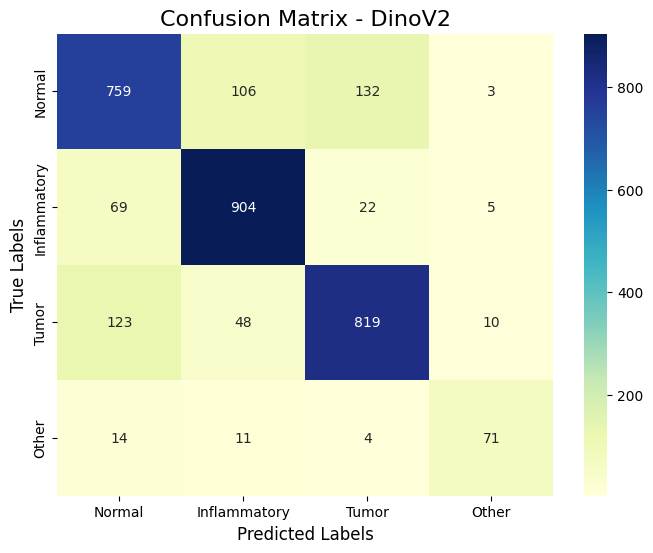

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your new confusion matrix data
data = np.array([
    [759, 106, 132,   3],
    [ 69, 904,  22,   5],
    [123,  48, 819,  10],
    [ 14,  11,   4,  71]
])

# Labels for the axes
labels = ['Normal', 'Inflammatory', 'Tumor', 'Other']

# Create the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu", cbar=True, xticklabels=labels, yticklabels=labels)

# Add title and labels
ax.set_title('Confusion Matrix - DinoV2', fontsize=16)
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels', fontsize=12)

# Display the heatmap
plt.show()


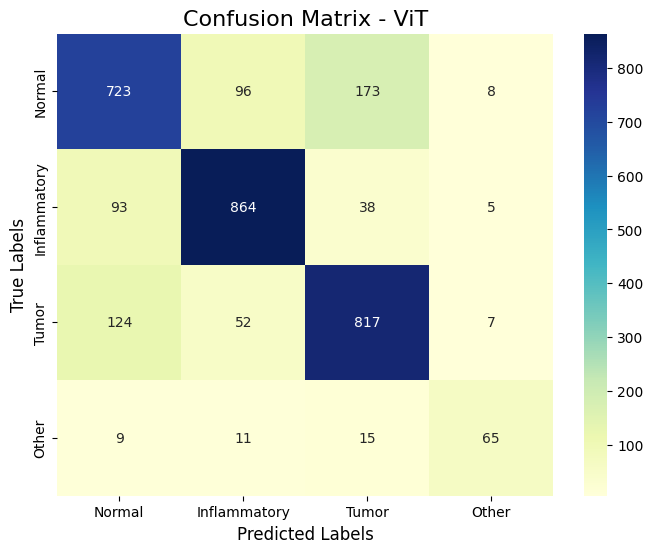

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your new confusion matrix data
data = np.array([
    [723,  96, 173,   8],
    [ 93, 864,  38,   5],
    [124,  52, 817,   7],
    [  9,  11,  15,  65]
])

# Labels for the axes
labels = ['Normal', 'Inflammatory', 'Tumor', 'Other']

# Create the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu", cbar=True, xticklabels=labels, yticklabels=labels)

# Add title and labels
ax.set_title('Confusion Matrix - ViT', fontsize=16)
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels', fontsize=12)

# Display the heatmap
plt.show()
